Create a fresh environment with Python v3.11 e.g. `conda create -n "lucj_test" python=3.11`. Make sure to select `lucj_test` as the active kernel in your IDE.

Then run the following, either in the notebook with `!` or in a terminal without:

In [ ]:
# ! pip install openfermionpyscf
# ! pip install pylatexenc
# ! pip install ffsim
# ! pip install symmer
# ! pip install --upgrade numpy==1.26.4 # downgrade numpy, even though symmer won't be happy
# # NOTE: symmer also won't be happy about the older version of qiskit, but it should still work
# ! pip install "iqm-client[qiskit]"

Connect to the IQM client and retreive backend:

In [4]:
from iqm.iqm_client import IQMClient
from iqm.qiskit_iqm import IQMBackend
with open("../token.txt", 'r') as textfile:
    # save your API token in a text file - do not distribute this or accidentally push to GitHub
    TOKEN = textfile.read()
# cocos_url = "https://cocos.resonance.meetiqm.com/sirius"
cocos_url = "https://cocos.resonance.meetiqm.com/garnet"
# cocos_url = "https://cocos.resonance.meetiqm.com/emerald-fe33b793-44a0-42d6"
client = IQMClient(cocos_url, token=TOKEN)
backend = IQMBackend(client=client)

/home/fredd/miniconda3/envs/lucj_test/lib/python3.11/site-packages/iqm/iqm_client/iqm_client.py:142: UserWarning: Your IQM Client version 23.8 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 22.3 <= iqm-client < 23.0.
  warnings.warn(version_incompatibility_msg)


If the IQM server is down or a device is not working, can also test with a fake backend:

In [4]:
# from iqm.qiskit_iqm.fake_backends.fake_garnet import IQMFakeGarnet
# backend = IQMFakeGarnet()

LUCJ circuit function using `ffsim` package:

In [2]:
import numpy as np
import ffsim
from typing import Tuple, List
from qiskit import QuantumCircuit, QuantumRegister, transpile
from pyscf.cc import CCSD

def get_lucj_circuit(
        ccsd_obj: CCSD, 
        n_reps: int = 1, 
        pairs_aa: List[Tuple[int]] = None, 
        pairs_ab: List[Tuple[int]] = None,
        ab_coupling_interval: int = 1, # only used if pairs_ab not set
        homo_lumo_expansion: bool = True
    ) -> QuantumCircuit:
    """
    """
    norb, nelec = int(ccsd_obj.mol.nao), ccsd_obj.mol.nelec
    # initialize from ccsd t2 amplitudes (calculated with PySCF)
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(ccsd_obj.t2, n_reps=n_reps)
    if pairs_aa is None:
        # Setting up square "ladder" interaction graph, same-spin couplings on a line topology:
        pairs_aa = [(p, p + 1) for p in range(norb - 1)]
    if pairs_ab is None:
        # diagonal coulomb interactions between up/down electrons sharing same spatial orbital
        pairs_ab = [(p,p) for p in range(0,norb,ab_coupling_interval)]

    interaction_pairs = (pairs_aa, pairs_ab)
    # enforce locality constraints (i.e. to respect the interaction graph specified above):
    lparams = ucj_op.to_parameters(interaction_pairs=interaction_pairs)
    lucj_op = ffsim.UCJOpSpinBalanced.from_parameters(
        lparams, norb=norb, n_reps=n_reps, interaction_pairs=interaction_pairs,
        with_final_orbital_rotation=False)
    # Create a QuantumCircuit, initialized from the HF state:
    qubits = QuantumRegister(2 * norb, name="q")
    circuit = QuantumCircuit(qubits)
    circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)#; circuit.barrier()
    circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(lucj_op), qubits)
    circuit = circuit.decompose().decompose()
    if homo_lumo_expansion:
        # lightcone optimization
        n_gates = len(circuit.data)
        n_gates_prior = None
        while n_gates != n_gates_prior:
            n_gates_prior = n_gates
            drop_gate_indices = []
            for index,gate in enumerate(circuit.data):
                if gate.name == "xx_plus_yy":    
                    gate_qubits = {q._index for q in gate.qubits}
                    gate_intersections = [gate_prior.name for gate_prior in circuit.data[:index] if gate_prior.name != 'barrier' and gate_qubits.intersection({q._index for q in gate_prior.qubits})!=set()]
                    if gate_intersections == [] or gate_intersections == ['x', 'x']:
                        drop_gate_indices.append(index)
            drop_gate_indices = list(sorted(set(drop_gate_indices)))
            for i,index in enumerate(drop_gate_indices):
                circuit.data.pop(index-i)
            n_gates = len(circuit.data)
    # reorder spin convention uuuu...dddd... -> udududud...
    circuit = transpile(circuit, initial_layout={q:2*(i%norb)+(i//norb) for i,q in enumerate(qubits)}, optimization_level=0)
    return circuit

Define your molecule and build Hamiltonian:

In [28]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from openfermion import jordan_wigner
from symmer.operators import PauliwordOp, QuantumState

basis = "sto-3g"
multiplicity = 1
charge = 0
geometry = [('Li',(0,0,0)),('H',(0,0,1))]

molecule = MolecularData(geometry, basis, multiplicity, charge)
run_pyscf(molecule,run_scf=True)

Run Coupled-Cluster and build the LUCJ circuit:

E(CCSD) = -7.784454825910903  E_corr = -0.017092690162338


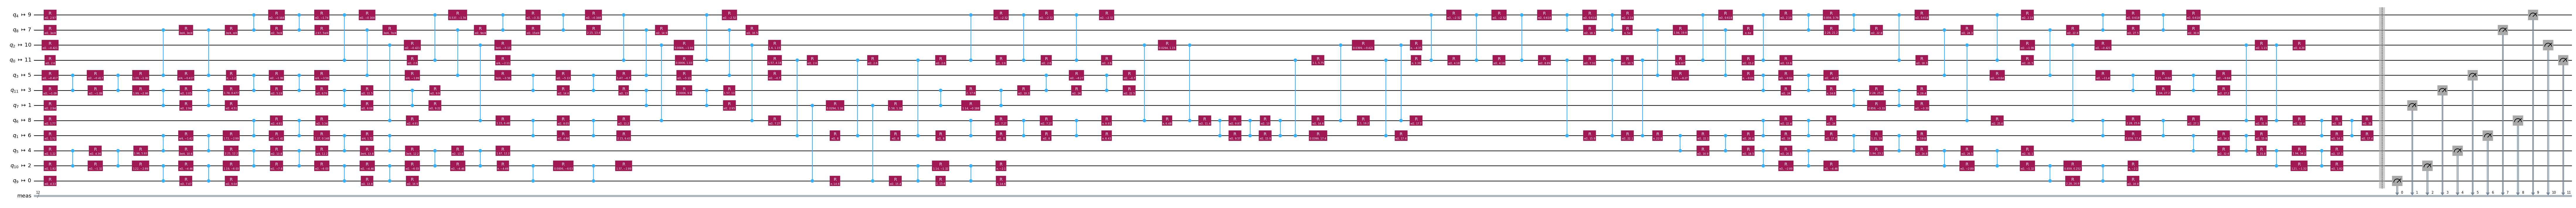

In [4]:
mol = molecule._pyscf_data['mol']
hf = molecule._pyscf_data['scf']
ccsd = CCSD(hf).run()
qc_lucj = get_lucj_circuit(ccsd)
qc = qc_lucj.copy()
qc.measure_all()
qc = transpile(qc, backend=backend, optimization_level=3)
qc.draw('mpl', fold=240, scale=0.8, idle_wires=False)

Submit the circuit as a job:

In [8]:
n_shots = 2**13
job = backend.run([qc], shots=n_shots)

Check the status:

In [9]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

In [7]:
# Load emerald job if url is working
# emerald_cocos_url = "https://cocos.resonance.meetiqm.com/emerald-fe33b793-44a0-42d6"
# emerald_client = IQMClient(emerald_cocos_url, token=TOKEN)
# emerald_backend = IQMBackend(client=emerald_client)
# emerald_job_id = "01963eca-5537-7173-81a4-1a03ad24e960"
# emerald_job = emerald_backend.retrieve_job(job_id=emerald_job_id)

# Hacky stand in for two garnet jobs
emerald_cocos_url = "https://cocos.resonance.meetiqm.com/garnet"
emerald_client = IQMClient(emerald_cocos_url, token=TOKEN)
emerald_backend = IQMBackend(client=emerald_client)
emerald_job_id = "01964414-6837-7d61-babf-f6e1ccd97a6b"
emerald_job = emerald_backend.retrieve_job(job_id=emerald_job_id)

garnet_cocos_url = "https://cocos.resonance.meetiqm.com/garnet"
garnet_client = IQMClient(garnet_cocos_url, token=TOKEN)
garnet_backend = IQMBackend(client=garnet_client)
garnet_job_id = "01968874-a91b-7773-a469-da2677d5bfee"
garnet_job = garnet_backend.retrieve_job(job_id=garnet_job_id)

/home/fredd/miniconda3/envs/lucj_test/lib/python3.11/site-packages/iqm/iqm_client/iqm_client.py:142: UserWarning: Your IQM Client version 23.8 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 22.3 <= iqm-client < 23.0.
  warnings.warn(version_incompatibility_msg)
/home/fredd/miniconda3/envs/lucj_test/lib/python3.11/site-packages/iqm/iqm_client/iqm_client.py:142: UserWarning: Your IQM Client version 23.8 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 22.3 <= iqm-client < 23.0.
  warnings.warn(version_incompatibility_msg)


Once the job is finished, get the measurement output:

In [13]:
from collections import Counter
def valid_config(config_str):
    # validate correct number of alpha/beta particles:
    alpha_str = config_str[::2]
    beta_str = config_str[1::2]
    return (Counter(alpha_str)['1'], Counter(beta_str)['1']) == mol.nelec

max_configs = 200 # truncate by keeping only the high-frequency configurations if the number of configs is too large

def select_configurations(job):
    """
    Given a job object, select the most important configurations from the results.
    """
    measurement_dict = job.result().results[0].data.counts
    # if the measurement are in hex, convert to bin: (this is the case when using a FakeBackend)
    if any([not set(m).issubset({'0','1'}) for m in measurement_dict]):
        measurement_dict = {format(int(k, base=16), f'0{mol.nao*2}b'):v for k,v in measurement_dict.items()}
    # reverse order of qubits:
    measurement_dict = {k[::-1]:v for k,v in measurement_dict.items()}
    # postselect configs with correct symmetry:
    measurement_dict = {k:v for k,v in measurement_dict.items() if valid_config(k)}
    # reorder in decreasing measuemenent frequency
    measurement_dict = dict(sorted(measurement_dict.items(), key=lambda x:x[1])[::-1])
    configurations, frequencies = zip(*measurement_dict.items())
    configurations = list(configurations[:max_configs]) # truncate the configuration space, noting these are ordered by measurement frequency
    # manually append the Hartree-Fock config if missing:
    hf_str = '1'*mol.nelectron + '0'*(2*mol.nao-mol.nelectron)
    if not hf_str in configurations:
        configurations.append(hf_str)    
    print(f"\nPercentage of measurements in the correct particle sector: {100 * sum(frequencies) / n_shots: .3f} %")
    return configurations

emerald_configurations = select_configurations(emerald_job)
garnet_configurations = select_configurations(garnet_job)



Percentage of measurements in the correct particle sector:  17.480 %

Percentage of measurements in the correct particle sector:  12.646 %


Now we have a Hamiltonian $H$ and a set of measurements - it's QSCI time!

Need to define a function that takes two basis states (or _electron configurations_) $\ket{i}$ and $\ket{j}$ and returns the matrix element $\bra{i} H \ket{j}$.

Here is an inefficient version:

In [14]:
def matrix_element(hamiltonian: PauliwordOp, i_str: str, j_str: str) -> float:
    psi_i = QuantumState.from_dictionary({i_str:1})
    psi_j = QuantumState.from_dictionary({j_str:1})
    return (psi_i.dagger * hamiltonian * psi_j).real

def get_selected_configuration_matrix(hamiltonian: PauliwordOp, configs: List[str]) -> np.ndarray[float]:
    """ Constructs the interaction matrix H_ij = <i|H|j>
    """
    matrix = np.zeros((len(configs),len(configs)),dtype=float)
    # this matrix is symmetric, so only build the upper triangle and then mirror
    for i,i_str in enumerate(configs):
        for j,j_str in enumerate(configs[i:]):
            matrix[i,j+i] = matrix_element(hamiltonian, i_str, j_str)
    matrix[np.tril_indices(len(configs), -1)] = matrix.T[np.tril_indices(len(configs), -1)]
    return matrix

Finally, solve the selected subspace matrix to get the final QSCI energy:

In [13]:
# eigvals, eigvecs = np.linalg.eigh(selected_subspace_matrix)
# e0 = eigvals[0]
# psi0 = QuantumState.from_dictionary(dict(zip(configurations, eigvecs[:,0])))

# print(f'The QSCI energy is {e0: .5f} Ha, yielding an FCI error of {e0 - molecule.fci_energy: .5f} Ha\n')
# print('The wavefunction is:\n')
# print(psi0.sort())

You can also get excited states like this:

In [14]:
# psi1 = QuantumState.from_dictionary(dict(zip(configurations, eigvecs[:,1])))
# psi2 = QuantumState.from_dictionary(dict(zip(configurations, eigvecs[:,2])))
# # etc...

# psi1.dagger * H * psi1

and compare with FCI excited state energies:

In [15]:
from matplotlib import pyplot as plt
from pyscf.fci import FCI
from math import comb

fci = FCI(hf)

total_configs = comb(mol.nao, mol.nelec[0]) * comb(mol.nao, mol.nelec[1])
fci.nroots = total_configs # maximum number of configurations
fci_energies, _ = fci.kernel()

In [16]:
# EV_FACTOR = 27.2114

# plt.plot((eigvals[:6]-eigvals[0])*EV_FACTOR, color='black', label='QSCI energies')
# plt.plot((fci_energies[:6]-fci_energies[0])*EV_FACTOR, color='black', ls=':', label='FCI energies')
# plt.xlabel('Excited state index')
# plt.ylabel('Energy [eV]')
# plt.title(f"Job {job_id[-4:]}")
# plt.legend()
# plt.show()

In [16]:
# Calculate energies from Emerald job
selected_subspace_matrix = get_selected_configuration_matrix(H, emerald_configurations)
em_eigvals, em_eigvecs = np.linalg.eigh(selected_subspace_matrix)

# Calculate energies from Garnet job
selected_subspace_matrix = get_selected_configuration_matrix(H, garnet_configurations)
ga_eigvals, ga_eigvecs = np.linalg.eigh(selected_subspace_matrix)

In [17]:
# Range of energies to display from ground state up in eV
EV_RANGE = 10
EV_FACTOR = 27.2114

ev_fci = fci_energies * EV_FACTOR
ground = ev_fci[0]
ev_fci -= ground
lowest_fci_mask = ev_fci < EV_RANGE
fci_plot_vals = ev_fci[lowest_fci_mask]

ev_eigvals = em_eigvals * EV_FACTOR
ev_eigvals -= ground
lowest_eigvals_mask = ev_eigvals < EV_RANGE
lowest_eigvals = ev_eigvals[lowest_eigvals_mask]
emerald_plot_vals = lowest_eigvals

ev_eigvals = ga_eigvals * EV_FACTOR
ev_eigvals -= ground
lowest_eigvals_mask = ev_eigvals < EV_RANGE
lowest_eigvals = ev_eigvals[lowest_eigvals_mask]
garnet_plot_vals = lowest_eigvals

energy_ladders = fci_plot_vals, emerald_plot_vals, garnet_plot_vals

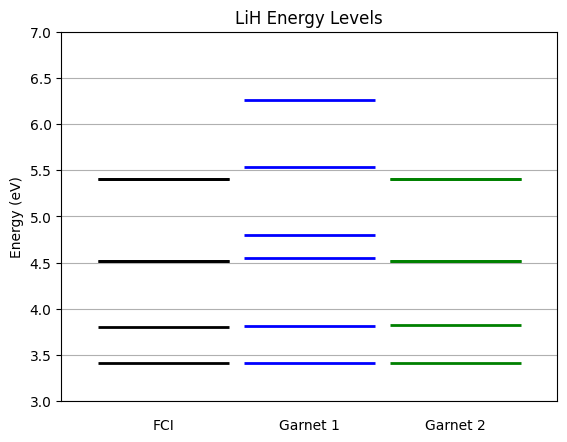

In [18]:

level_width = 0.9       # Width of each energy line
spacing = 1.0           # Horizontal spacing between columns
margin = 0.2
colors = "black", "blue", "green"
labels = "FCI", "Garnet 1", "Garnet 2"

fig, ax = plt.subplots()
for col_index, levels in enumerate(energy_ladders):
    x_center = col_index * spacing
    for energy in levels:
        ax.hlines(
            y=energy, 
            xmin=x_center - level_width/2, 
            xmax=x_center + level_width/2, 
            color=colors[col_index], 
            linewidth=2
            )
    ax.text(x_center, 2.7, f"{labels[col_index]}", ha='center')

ax.set_ylabel('Energy (eV)')
ax.set_title(f'LiH Energy Levels')
ax.set_xlim(-spacing/2-margin, spacing * (len(energy_ladders)-0.5) + margin)
ax.set_ylim(3, 7)
ax.set_xticks([])
ax.grid(True)

... although we need better methods to make sure the correct configurations are appearing in the measurement output.

In [27]:
from pprint import pprint
np.set_printoptions(precision=3, suppress=True)
for ladder in energy_ladders:
    pprint(ladder)

array([0.   , 3.416, 3.809, 4.514, 4.514, 5.403, 5.403])
array([0.001, 3.418, 3.81 , 4.552, 4.555, 5.533, 5.535])
array([0.001, 3.417, 3.809, 4.555, 4.798, 5.535, 6.26 ])


In [49]:
emerald_set = set(emerald_configurations)
garnet_set = set(garnet_configurations)
emerald_only_configs = emerald_set.difference(garnet_set)

# for i in range(7):
#     psi = QuantumState.from_dictionary(dict(zip(emerald_configurations, em_eigvecs[:,i])))

def difference_magnitude(state_index):
    """
    Calculate the sum of the magnitudes of the basis states missing from garnet.
    """
    psi = QuantumState.from_dictionary(dict(zip(emerald_configurations, em_eigvecs[:,state_index])))
    psi = psi.to_dictionary
    diff_mag = 0
    for bitstring, magnitude in psi.items():
        if bitstring in emerald_only_configs:
            diff_mag += abs(magnitude)
    return diff_mag

missing_mags = []
for i in range(7):
    missing_mags.append(difference_magnitude(i))

ls = list(zip(fci_plot_vals, missing_mags))
[(f"{x:.3f} eV", f"{y:.3f}") for x, y in ls]
# [(f"{x:.3f} eV", f"{y:.3f}") for x, y in j for j in ls]

[('0.000 eV', '0.004'),
 ('3.416 eV', '0.007'),
 ('3.809 eV', '0.005'),
 ('4.514 eV', '0.015'),
 ('4.514 eV', '0.188'),
 ('5.403 eV', '0.016'),
 ('5.403 eV', '0.288')]